In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
import mlflow
from src import models
import torch.nn.functional as F


mltrainer.__version__

'0.1.129'

In [2]:

def test_model(model, teststreamer):
    y_true = []
    y_pred = []
    #model = model.to("cpu")

    #testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)

        yhat = model(X)
        yhat = yhat.argmax(dim=1) # we get the one with the highest probability
        y_pred.append(yhat.cpu().tolist())
        y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]
    return y, yhat

def plot_confusion_matrix(cfm):
    plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
    plot.set(xlabel="Predicted", ylabel="Target")
    plt.show()

# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference



In [3]:
def train_model(trainstreamer, teststreamer, config, settings=None):

        loss_fn = torch.nn.CrossEntropyLoss()

        with mlflow.start_run():
            optimizer = torch.optim.Adam

            if settings==None:
                # default settings
                settings = TrainerSettings(
                    epochs=15,
                    metrics=[accuracy, f1micro, f1macro, precision, recall],
                    logdir="logs/heart2D",
                    train_steps=len(trainstreamer) // 5,
                    valid_steps=len(teststreamer) // 5,
                    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
                    scheduler_kwargs={"factor": 0.5, "patience": 2},
                    earlystop_kwargs={"patience": 8},
                )



            trainer = Trainer(
                model=model,
                settings=settings,
                loss_fn=loss_fn,
                optimizer=optimizer,
                traindataloader=trainstreamer.stream(),
                validdataloader=teststreamer.stream(),
                scheduler= config["scheduler"],
            )

            mlflow.set_tag("model", config["model"])
            mlflow.set_tag("dataset", "heart_big_SMOTE")
            mlflow.log_param("scheduler", str(trainer.scheduler).split(".")[-1])
            mlflow.log_param("earlystop", str(settings.earlystop_kwargs))

            base_config = {
                "hidden": config["hidden"],
                "dropout": config["dropout"],
                "num_classes": config["num_classes"],
                "num_heads": config["num_heads"],
                "num_blocks": config["num_blocks"],
                "shape": config["shape"]
            }
            mlflow.log_params(base_config)
            mlflow.log_param("epochs", settings.epochs)
            mlflow.log_param("shape0", config["shape"])
            mlflow.log_param("optimizer", str(optimizer))
            mlflow.log_params(settings.optimizer_kwargs)
            trainer.loop()



In [36]:
datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [37]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [38]:
#trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')


In [39]:
# 2D dataset with shape = (16, 12)
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset

(Heartdataset2D (#275000), Heartdataset2D (#21892))

In [ ]:
# 1D dataset
#traindataset = datasets.HeartDataset(trainfile, target="target")
#testdataset = datasets.HeartDataset(testfile, target="target")

In [40]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [22]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
    )

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        # feel free to change the input parameters of the constructor
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone() # skip connection
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity) # Add & Norm skip
        identity = x.clone() # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity) # Add & Norm skip
        return x

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Define the 2D ResNet Block
class ResNetBlock2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If input and output sizes do not match, apply a projection (1x1 conv)
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x  # Store the input for the skip connection

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Add the input to the output (skip connection)
        x += self.projection(identity)
        x = self.relu(x)

        return x


class Transformer2DResNet(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()

        # Modify the initial Conv2D to accept 1 input channels 
        self.conv2d = nn.Conv2d(
            in_channels=1,  # Adjusted input channels if needed
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        #print('2d conv')

        # Add ResNet Block (2D)
        self.resnet_block = ResNetBlock2D(config["hidden"], config["hidden"])
        print('resnet block')

        # Positional Encoding for Transformer input
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])
        #print('positional encoding')

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        # Final output layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"] // 2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"] // 2, config["num_classes"]),
        )

# - streamer:         (batch, seq_len, channels)
# - conv1d:           (batch, channels, seq_len)
# - pos_encoding:     (batch, seq_len, channels)
# - gru (batchfirst): (batch, seq_len, channels)
# - attention:        (batch, seq_len, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
       # print("input", x.shape)
        x = x.view(32, 1, 16, 12) # reshape to 2D
       # print("input", x.shape)
        # Apply Conv2D to the input (convert from (batch, channels, height, width) to (batch, hidden, height, width))
        x = self.conv2d(x)  # (batch, hidden, height//2, width//2)
       # print("input afte cov2", x.shape)
        # Apply ResNet Block (2D)
        x = self.resnet_block(x)  # (batch, hidden, height//2, width//2)

        # Apply positional encoding (convert back to (batch, seq_len, channels))
        x = self.pos_encoder(x.flatten(2).transpose(1, 2))  # Flatten and transpose to (batch, seq_len, channels)

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Global Average Pooling
        x = x.mean(dim=1)  # (batch, hidden)

        # Final classification layers
        x = self.out(x)  # (batch, num_classes)
        return x

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.fc2 = nn.Linear(channel // reduction, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Squeeze: Global Average Pooling
        b, c, _, _ = x.size()  # batch_size, channels, height, width
        squeeze = F.adaptive_avg_pool2d(x, (1, 1))  # (b, c, 1, 1)
        squeeze = squeeze.view(b, c)  # Flatten to (b, c)

        # Excitation: Fully connected layers + sigmoid activation
        excitation = F.relu(self.fc1(squeeze))
        excitation = self.sigmoid(self.fc2(excitation)).view(b, c, 1, 1)  # (b, c, 1, 1)

        # Recalibration: Re-weight the original feature maps
        return x * excitation.expand_as(x)



class Transformer2DResNetSE(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()

        # Initial Conv2D Layer
        self.conv2d = nn.Conv2d(
            in_channels=1,  # Adjusted input channels if needed
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )

        # ResNet Block (2D)
        self.resnet_block = ResNetBlock2D(config["hidden"], config["hidden"])

        # Squeeze-and-Excitation (SE) block after ResNet block
        self.se_block = SEBlock(config["hidden"])

        # Positional Encoding for Transformer input
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        # Final output layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"] // 2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"] // 2, config["num_classes"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reshape input to 2D (batch, channels, height, width)
        x = x.view(x.size(0), 1, 16, 12)

        # Apply Conv2D to the input
        x = self.conv2d(x)  # (batch, hidden, height, width)

        # Apply ResNet Block (2D)
        x = self.resnet_block(x)  # (batch, hidden, height//2, width//2)

        # Apply SE Block to recalibrate features
        x = self.se_block(x)

        # Apply positional encoding (convert back to (batch, seq_len, channels))
        x = self.pos_encoder(x.flatten(2).transpose(1, 2))  # Flatten and transpose to (batch, seq_len, channels)

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Global Average Pooling
        x = x.mean(dim=1)  # (batch, hidden)

        # Final classification layers
        x = self.out(x)  # (batch, num_classes)
        return x


2025-01-26 16:39:15.531 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-163915
2025-01-26 16:39:15.532 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer2DResNetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
Transformer2DResNetSE(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SEBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (

100%|██████████| 2264/2264 [00:55<00:00, 40.73it/s]
2025-01-26 16:40:12.760 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4273 test 0.2853 metric ['0.8971', '0.8971', '0.6821', '0.8971', '0.9009']
100%|██████████| 2264/2264 [00:55<00:00, 40.98it/s]
2025-01-26 16:41:09.665 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2473 test 0.2512 metric ['0.9000', '0.9000', '0.6846', '0.9000', '0.9089']
100%|██████████| 2264/2264 [00:56<00:00, 40.25it/s]
2025-01-26 16:42:07.545 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2005 test 0.2004 metric ['0.9269', '0.9269', '0.7339', '0.9269', '0.9292']
100%|██████████| 2264/2264 [00:55<00:00, 40.55it/s]
2025-01-26 16:43:05.046 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1699 test 0.1900 metric ['0.9299', '0.9299', '0.7476', '0.9299', '0.9288']
100%|██████████| 2264/2264 [00:55<00:00, 40.56it/s]
2025-01-26 16:44:02.552 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1446 test 0.2412 met

{'model': 'Transformer2DResNetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


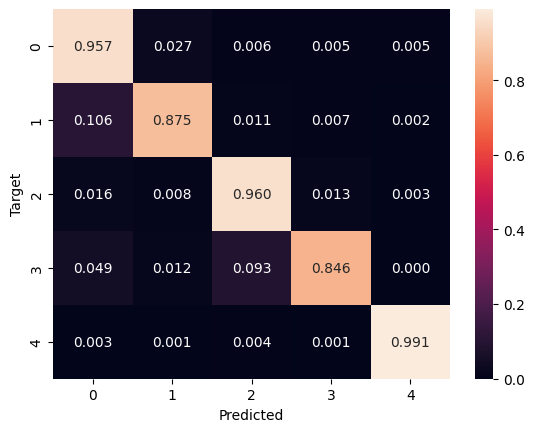

In [42]:

modelname= "Transformer2DResNetSE"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = Transformer2DResNetSE(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
plot_confusion_matrix(cfm)


In [43]:
class MultiHeadAttentionWithSE(nn.Module):
    def __init__(self, hidden_dim, num_heads, reduction=16, dropout=0.1):
        super(MultiHeadAttentionWithSE, self).__init__()
        
        # Multi-Head Attention layer
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        
        # Squeeze-and-Excitation block
        self.se_block = SqueezeExcitation(hidden_dim, reduction)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout),
        )
        
        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention mechanism with residual connection and layer normalization
        attn_output, _ = self.attn(x, x, x)  # (batch, seq_len, hidden)
        x = self.layer_norm1(x + self.dropout(attn_output))  # (batch, seq_len, hidden)
        
        # Apply Squeeze-and-Excitation block to recalibrate the channel attention
        x = self.se_block(x)  # Apply SE block on the output of attention

        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.ffn(x)
        x = self.layer_norm2(x + self.dropout(ffn_output))

        return x


class Transformer2DResNetWithAttention(nn.Module):
    def __init__(self, config: dict) -> None:
        super(Transformer2DResNetWithAttention, self).__init__()

        self.conv2d = nn.Conv2d(in_channels=1, out_channels=config["hidden"], kernel_size=3, stride=2, padding=1)

        # Adding ResNet Block (already defined in your code)
        self.resnet_block = ResNetBlock2D(config["hidden"], config["hidden"])

        # Add the SE block after the ResNet Block
        self.se_block = SqueezeExciteBlock(config["hidden"])

        # Transformer-related components
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        # Final output layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"] // 2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"] // 2, config["num_classes"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), 1, 16, 12)  # Reshape to 2D (batch, channels, height, width)

        # Apply Conv2D
        x = self.conv2d(x)

        # Apply ResNet Block
        x = self.resnet_block(x)

        # Apply Squeeze-and-Excite Block
        x = self.se_block(x)

        # Apply positional encoding and flatten the input for transformer
        x = self.pos_encoder(x.flatten(2).transpose(1, 2))

        # Pass through transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Global average pooling
        x = x.mean(dim=1)

        # Final output layer
        x = self.out(x)
        return x

In [12]:

modelname= "Transformer2DResNetWithAttention"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNetWithAttention(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
plot_confusion_matrix(cfm)

2025-01-26 16:53:46.189 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-165346
2025-01-26 16:53:46.189 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer2DResNetWithAttention', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
Transformer2DResNetWithAttention(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SqueezeExciteBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:

modelname= "Transformer2DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNet(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
plot_confusion_matrix(cfm)

In [ ]:
modelname= "GRU"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.GRU(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
plot_confusion_matrix(cfm)